In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd
from playwright.async_api import async_playwright

In [2]:
# "Hey, open up a browser"
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)

# Create a new browser window
page = await browser.new_page()

# Tell it to go to this page
await page.goto("https://www.1522.eu/mappatura-1522/")

<Response url='https://www.1522.eu/mappatura-1522/' request=<Request url='https://www.1522.eu/mappatura-1522/' method='GET'>>

In [5]:
html_content = await page.content()
await browser.close()
soup = BeautifulSoup(html_content, 'html.parser')

<!DOCTYPE html>
<html class="no-js no-svg" lang="it-IT"><head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="https://gmpg.org/xfn/11" rel="profile"/>
<title>Mappatura 1522 – 1522</title>
<link href="https://www.1522.eu/mappatura-1522/" hreflang="it" rel="alternate"/>
<link href="//fonts.googleapis.com" rel="dns-prefetch"/>
<link href="//s.w.org" rel="dns-prefetch"/>
<link href="https://www.1522.eu/feed/" rel="alternate" title="1522 » Feed" type="application/rss+xml"/>
<link href="https://www.1522.eu/comments/feed/" rel="alternate" title="1522 » Feed dei commenti" type="application/rss+xml"/>
<link href="https://www.1522.eu/wp-content/plugins/login-with-ajax/widget/widget.css?ver=3.1.7" id="login-with-ajax-css" media="all" rel="stylesheet" type="text/css"/>
<link href="https://www.1522.eu/wp-content/plugins/askmechat-widget/css/askmechat.widget.custom.css?ver=4.7.3" id="askmechat_widget_custom-css" media="all" rel="stylesheet" 
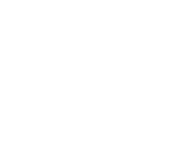
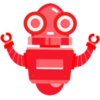
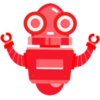
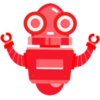

In [6]:
soup

In [36]:
province = []
comuni = []
centri = []
contatti = []
orari = []

regioni = soup.find_all('div', class_='mks_accordion_content')
for regione in regioni:
  divs = regione.find_all('div')
  for i in range(0, len(divs), 6):
     provincia = divs[0].text.strip()
     comune = divs[1].text.strip()
     centro = divs[2].text.strip()
     indirizzo = divs[3].text.strip()
     
     print(indirizzo)

     contatto = divs[4].text.strip()
     orario = divs[5].text.strip()
     
     
     province.append(provincia)
     comuni.append(comune)
     centri.append(centro)
     indirizzi.append(indirizzo)
     contatti.append(contatto)
     orari.append(orario)

data = {
    'Provincia': province,
    'Comune': comuni,
    'Centro': centri,
    'Indirizzo': indirizzi,
    'Contatto': contatti,
    'Orario': orari
}

# Create a DataFrame from the dictionary
# df = pd.DataFrame(data)

Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Spaventa, 47
Indirizzo: Via Aldo Moro,1
Indirizzo: Via Aldo Moro,1
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Valle, 106
Indirizzo: Via Lucrezia della Va

In [33]:
print("Province length:", len(province))
print("Comuni length:", len(comuni))
print("Centri length:", len(centri))
print("Indirizzi length:", len(indirizzi))
print("Contatti length:", len(contatti))
print("Orari length:", len(orari))

Province length: 406
Comuni length: 406
Centri length: 406
Indirizzi length: 904
Contatti length: 406
Orari length: 406


In [ ]:
# Initialize dictionary to store results
centers_data = []


In [ ]:
accordion_items = soup.find_all('div', class_='mks_accordion_item')

for item in accordion_items:
    center_info = {}
    
    # Get region name from heading
    heading = item.find('div', class_='mks_accordion_heading')
    if heading:
        center_info['Regione'] = heading.get_text(strip=True).replace('\xa0', ' ')
    
    # Define fields to extract
    fields = ['Provincia', 'Comune', 'Centro', 'Indirizzo', 'Contatti', 'Orari']
    
    # Find all div elements within the accordion content
    content_div = item.find('div', class_='mks_accordion_content')
    if content_div:
        for div in content_div.find_all('div'):
            # Skip if div doesn't have text
            if not div.text:
                continue
                
            # Check each field
            for field in fields:
                if div.strong and field in div.strong.text:
                    # Extract text after the field name
                    content = re.sub(f'^{field}:\\s*', '', div.text.strip())
                    # Remove the field name and any leading/trailing whitespace
                    content = re.sub(f'^{field}.*?(?=\S)', '', content).strip()
                    # For contacts, extract all phone numbers
                    if field == 'Contatti':
                        phone_numbers = re.findall(r'\d+', content)
                        center_info[field] = '; '.join(phone_numbers)
                    else:
                        center_info[field] = content
    
    centers_data.append(center_info)

# Create DataFrame
df = pd.DataFrame(centers_data)


In [ ]:
df

In [ ]:
df.to_csv('../data/centri.csv', index=False, encoding='UTF-8')

### Geolocating

In [ ]:
import pandas as pd
import requests
import folium
import time
import random

def get_coordinates_from_osm(address):
    # Construct the URL for OSM Nominatim
    base_url = "https://nominatim.openstreetmap.org/search"
    
    # Parameters for the search
    params = {
        'q': f"{address}, Italia",
        'format': 'json',
        'limit': 1
    }
    
    # Headers to identify our application
    headers = {
        'User-Agent': 'AntiViolenceCentersMap/1.0 (md3934@columbia.edu)',
        'Accept-Language': 'it-IT,it'
    }
    
    try:
        # Add random delay between 1-2 seconds
        time.sleep(1 + random.random())
        
        response = requests.get(base_url, params=params, headers=headers)
        
        if response.status_code == 200:
            data = response.json()
            if data:
                return float(data[0]['lat']), float(data[0]['lon'])
        return None
    except Exception as e:
        print(f"Error getting coordinates for {address}: {e}")
        return None


# Function to create simplified address
def create_simplified_address(row):
    # Get the first city if multiple are listed
    primary_city = row['Comune'].split(',')[0].strip()
    return f"{row['Indirizzo']}, {primary_city}, {row['Provincia']}"

# Add simplified address column
df['simplified_address'] = df.apply(create_simplified_address, axis=1)

# Create empty columns for coordinates
df[['latitude', 'longitude']] = None

# Geocode addresses
print("Starting geocoding process...")
for idx, row in df.iterrows():
    coords = get_coordinates_from_osm(row['simplified_address'])
    print(row['simplified_address'])
    if coords:
        df.loc[idx, 'latitude'] = coords[0]
        df.loc[idx, 'longitude'] = coords[1]
        print(f"Coordinates found! {coords}")
    else:
        print("Coords not found.")

In [ ]:
df = pd.read_csv('../data/centri.csv')

df.drop_duplicates()
df.to_csv('../data/centri.csv', index=False, encoding='UTF-8-sig')

In [ ]:
# Show rows where either latitude or longitude is None/NaN
failed_geocoding = df[df['latitude'].isna() | df['longitude'].isna()]

# Display all columns for these rows
print("Centers that need manual geocoding:")
print(failed_geocoding[['Regione', 'Provincia', 'Comune', 'Centro', 'Indirizzo']])

In [ ]:
failed_geocoding

In [ ]:
# Dictionary with manual coordinates for failed geocoding
manual_coordinates = {
    # Create entries in format:
    # 'Center Name': {'lat': latitude, 'lon': longitude},
    'Antiviolenza La Fenice': {'lat': 42.6589, 'lon': 13.7044},  # Teramo
    'Antiviolenza Telefono Donna': {'lat': 40.6404, 'lon': 15.8056},  # Potenza
    'Antiviolenza Attivamente Coinvolte': {'lat': 38.7352, 'lon': 16.1564},  # Pizzo
    'Antiviolenza Il volo delle farfalle': {'lat': 40.2282, 'lon': 15.2667},  # Vallo della Lucania
    'Antiviolenza Marielle': {'lat': 44.0674, 'lon': 12.4503},  # Santarcangelo
    'Zero tolerance contro la violenza sulle donne': {'lat': 46.0643, 'lon': 13.2376},  # Udine
    'Antiviolenza Penelope': {'lat': 42.4168, 'lon': 12.1054},  # Viterbo
    'Antiviolenza Telefono Donna': {'lat': 44.3076, 'lon': 8.4801},  # Savona
    'Antiviolenza Felicita Morandi': {'lat': 45.8206, 'lon': 8.8257},  # Varese
    'Antiviolenza Parla con noi': {'lat': 43.9097, 'lon': 12.9137},  # Pesaro
    'Antiviolenza BeFree Molise di Isernia': {'lat': 41.5893, 'lon': 14.2334},  # Isernia
    'Antiviolenza Vercellese EOS': {'lat': 45.3207, 'lon': 8.4189},  # Vercelli
    'Antiviolenza  Sostegno Donna': {'lat': 40.4715, 'lon': 17.2292},  # Taranto
    'Antiviolenza Feminas': {'lat': 39.5625, 'lon': 8.8962},  # Sanluri
    'Antiviolenza CO.TU.LE.VI': {'lat': 38.0173, 'lon': 12.5145},  # Trapani
    'Associazione Donna chiama Donna': {'lat': 43.3186, 'lon': 11.3306},  # Siena
    'Antiviolenza': {'lat': 46.0748, 'lon': 11.1217},  # Trento
    'Antiviolenza Liberetutte': {'lat': 42.5636, 'lon': 12.6410},  # Terni
    'Antiviolenza donne contro la violenza': {'lat': 45.7371, 'lon': 7.3196},  # Aosta
    'CeAV- Centro Antiviolenza del Comune di Vicenza': {'lat': 45.5455, 'lon': 11.5354}  # Vicenza
}

In [ ]:

# Create a map centered on Italy
m = folium.Map(location=[42.504154, 12.646361], zoom_start=6)

# Add markers for each center
for idx, row in df_mapped.iterrows():
    popup_text = f"""
    <b>{row['Centro']}</b><br>
    {row['Indirizzo']}<br>
    {row['Comune']}, {row['Provincia']}<br>
    Tel: {row['Contatti']}<br>
    Orari: {row['Orari']}<br>
    """
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Save the map
m.save('antiviolence_centers_map.html')

# Print summary
print(f"\nGeocoding completed:")
print(f"Total centers: {len(df)}")
print(f"Successfully mapped: {len(df_mapped)}")
print(f"Failed to map: {len(df) - len(df_mapped)}")